In [1]:
#import models
import numpy as np
import h5py
import sys, os
import rospy
import rosbag
import math
from scipy.interpolate import interp1d
import h5py
import matplotlib.pylab as plt

from EventPreProcess import EventPreProcess
from dvs_msgs.msg import EventArray
from std_msgs.msg import Float64, Bool
from geometry_msgs.msg import Pose, Vector3, PoseStamped

In [2]:
#parameters of processing
frequency = 10 #Hz
bag_file_name = 'tactile_sensing_data/2020-08-18-14-09-04.bag'
h5_file_name = 'processed_data_10_Hz.hdf5'
time_window_size = 30
examples_per_edge = 3

In [3]:
bag_file = rosbag.Bag(bag_file_name)

events = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []

list_of_rotations = [[0,0,0], [0.2, 0, 0], [0, 0.2, 0], [-0.2, 0, 0], [0, -0.2, 0]]


for topic, msg, t in bag_file.read_messages(topics=['/contact_status', '/dvs/events', '/contact_angle']):
    if topic == '/dvs/events':
        for e in msg.events:
            event = [e.x, e.y, e.ts.to_nsec(), e.polarity]
            events.append(event)
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        if (len(contact_status) > 1):
            if (contact_status[-1] == True):
                best_rot_diff = 100
                best_rot_idx = 1
                i = 1
                for rot in list_of_rotations:
                    diff_vals = np.sqrt( np.power(rot[0] - msg.x, 2) +  np.power(rot[1] - msg.y, 2) + np.power(rot[2] - msg.z, 2) )
                    if best_rot_diff > diff_vals:
                        best_rot_diff = diff_vals
                        best_rot_idx = i
                    i = i + 1

                contact_case.append(best_rot_idx)
                contact_case_ts.append(t.to_nsec())
            else:
                contact_case.append(0)
                contact_case_ts.append(t.to_nsec())
        else:
            contact_case.append(0)
            contact_case_ts.append(t.to_nsec())


In [4]:
#interpolate
f = interp1d(contact_case_ts, contact_case, kind='previous')
contact_case_ts_int = range(min(contact_case_ts), max(contact_case_ts), int(1e9/frequency))
contact_case_int = f(contact_case_ts_int)

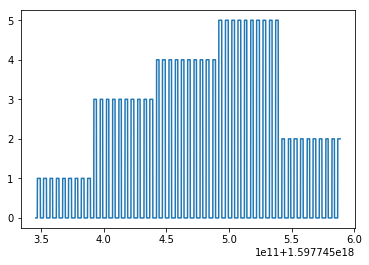

2432


In [5]:

plt.plot(contact_case_ts_int, contact_case_int)
plt.show()
print(len(contact_case_ts_int))

In [7]:

hf = h5py.File(h5_file_name, 'w')
hf.create_dataset('contact_status', data=contact_case_int)
hf.create_dataset('time_steps', data=contact_case_ts_int)

set_size = 1000
unprocessed_events = np.copy(events)

for i in range(0, len(contact_case_ts_int), set_size):
    start_idx=i
    end_idx=min([len(contact_case_ts_int), i+set_size])

    [event_frames, unprocessed_events] = EventPreProcess.ConcatenateEvents(unprocessed_events, contact_case_ts_int[start_idx:end_idx])
    #write data
    if i==0:
        hf.create_dataset('event_images', data=event_frames, maxshape=(None,None, None, None))
    else:
        hf['event_images'].resize(len(hf['event_images']) + len(event_frames), axis=0)
        hf["event_images"][-len(event_frames):] = event_frames
    del event_frames

hf.close()

Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 54
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finished: 55
Percentage finis

In [8]:

hf = h5py.File(h5_file_name, 'r+')
print('number of event images: {}'.format(len(hf['event_images'])))
hf.close()

number of event images: 2432


In [13]:
#Find rise/drop time and create windows accordingle
edge_locations = np.where(np.abs(np.diff(contact_case_int))>0)
edge_locations = np.array(edge_locations)[0].tolist()
print(edge_locations)

#Divide the data set into windows

def extract_edge_data(hf_file, edge_index_list, n_examples_per_edge=examples_per_edge, window_size=time_window_size, n_classes=6):
    for index in edge_index_list:

        for j in range(n_examples_per_edge):
            start_index = max([0, math.floor(index-window_size/2)])
            end_index = start_index + window_size
            if end_idx <= len(hf_file['contact_status']):
                reference_idx = range(int(start_index), int(end_index))
                one_hot_vector = [0] * n_classes
                one_hot_vector[int(hf_file['contact_status'][end_index])] = 1
                
                if not ('ex_input_image_idx' in hf_file.keys()):
                    hf_file.create_dataset('ex_input_image_idx', data=[reference_idx], maxshape=(None,None))
                    hf_file.create_dataset('ex_output', data=[one_hot_vector], maxshape=(None, None))
                else:
                    hf_file['ex_input_image_idx'].resize(len(hf_file['ex_input_image_idx']) + 1, axis=0)
                    hf_file["ex_input_image_idx"][len(hf_file['ex_input_image_idx'])-1] = reference_idx

                    hf_file['ex_output'].resize(len(hf_file['ex_output']) + 1, axis=0)
                    hf_file["ex_output"][len(hf_file['ex_output'])-1] = one_hot_vector

[12, 36, 61, 85, 113, 134, 164, 185, 214, 235, 261, 285, 314, 335, 363, 385, 413, 436, 463, 484, 514, 534, 564, 583, 613, 633, 663, 683, 712, 733, 760, 783, 813, 833, 864, 884, 910, 934, 964, 984, 1011, 1034, 1063, 1084, 1114, 1134, 1162, 1183, 1212, 1233, 1263, 1283, 1312, 1333, 1360, 1383, 1414, 1435, 1461, 1485, 1514, 1537, 1565, 1587, 1614, 1637, 1666, 1685, 1716, 1736, 1763, 1786, 1814, 1836, 1866, 1887, 1915, 1936, 1965, 1986, 2017, 2036, 2062, 2087, 2114, 2135, 2167, 2187, 2214, 2236, 2264, 2285, 2316, 2335, 2365, 2385, 2411]


In [14]:
#Divide the data set into windows

def create_dataset(hf_file, time_steps=50, n_classes=6):
    for i in range(time_steps, len(hf_file['event_images']) - time_steps):
        if (i%1000) == 0:
            print(i/float(len(hf_file['event_images'])))
        reference_idx = range(i-time_steps+1,i+1)
        one_hot_vector = [0] * n_classes
        one_hot_vector[int(hf_file['contact_status'][i])] = 1
        
        if i==time_steps:
            hf_file.create_dataset('ex_input_image_idx', data=[reference_idx], maxshape=(None,None))
            hf_file.create_dataset('ex_output', data=[one_hot_vector], maxshape=(None, None))
        else:
            hf_file['ex_input_image_idx'].resize(len(hf_file['ex_input_image_idx']) + 1, axis=0)
            hf_file["ex_input_image_idx"][len(hf_file['ex_input_image_idx'])-1] = reference_idx

            hf_file['ex_output'].resize(len(hf_file['ex_output']) + 1, axis=0)
            hf_file["ex_output"][len(hf_file['ex_output'])-1] = one_hot_vector

In [15]:
hf = h5py.File(h5_file_name, 'r+')
extract_edge_data(hf, edge_locations)
hf.close()

In [16]:
hf = h5py.File(h5_file_name, 'r+')
print(len(hf['ex_output']))
hf.close()

291


[144, 27, 30, 30, 30, 30]


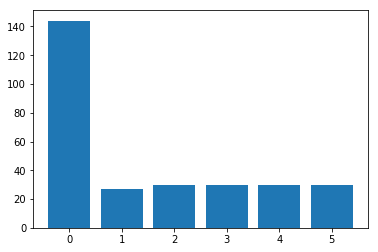

In [17]:
#analyze classes
hf = h5py.File(h5_file_name, 'r+')
counter = [0] * 6

for i in range(len(hf['ex_output'])):
    idx = list(hf['ex_output'][i]).index(1)
    counter[idx] = counter[idx] + 1

print(counter)
plt.bar(range(0,6),counter)
hf.close()

In [20]:
hf = h5py.File(h5_file_name, 'r+')
def equalize_representation(hf_file, class_counter, n_classes=6):
    for i in range(len(hf_file['ex_output'])):
        idx = list(hf['ex_output'][i]).index(1)
        
        if (np.random.rand() < (float(min(counter)) / counter[idx])):
            if 'ex_input_image_idx_equalized' in hf_file.keys():
                hf_file['ex_input_image_idx_equalized'].resize(len(hf_file['ex_input_image_idx_equalized']) + 1, axis=0)
                hf_file["ex_input_image_idx_equalized"][len(hf_file['ex_input_image_idx_equalized'])-1] = hf_file['ex_input_image_idx'][i]

                hf_file['ex_output_equalized'].resize(len(hf_file['ex_output_equalized']) + 1, axis=0)
                hf_file["ex_output_equalized"][len(hf_file['ex_output_equalized'])-1] = hf['ex_output'][i]
            else:
                hf_file.create_dataset('ex_input_image_idx_equalized', data=[hf_file['ex_input_image_idx'][i]], maxshape=(None,None))
                hf_file.create_dataset('ex_output_equalized', data=[hf_file['ex_output'][i]], maxshape=(None, None))

equalize_representation(hf, counter)

[29, 27, 28, 27, 26, 29]


<Container object of 6 artists>

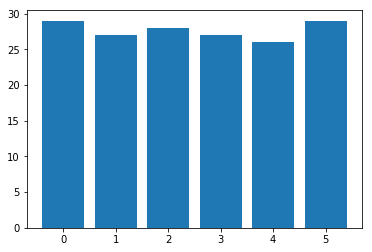

In [21]:
new_counter = [0] * 6

for i in range(len(hf['ex_output_equalized'])):
    idx = list(hf['ex_output_equalized'][i]).index(1)
    new_counter[idx] = new_counter[idx] + 1

print(new_counter)
plt.bar(range(0,6),new_counter)

In [22]:
print(len(hf['ex_output_equalized']))

166


In [23]:
hf.close()

In [33]:
print(np.mean(hf['event_images'][:,:,:,0]))
print(np.std(hf['event_images'][:,:,:,0]))
print(np.max(hf['event_images'][:,:,:,0]))
print(np.min(hf['event_images'][:,:,:,0]))


0.0008835273
0.031460017
21.0
0.0
